In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
import yfinance as yf


from datetime import date

In [109]:
risk_free = 0.035                                 #УКАЖИТЕ ГОДОВОЙ ДОХОД БЕЗРИСКОВЫХ ИНВЕСТИЦИЙ
total_money = 1000                                #УКАЖИТЕ НА КАКУЮ СУММУ СОБРАТЬ ПОРТФЕЛЬ

listtick = []
#listtick = "aflt.me gazp.me gche.me gltr.me irao.me mgnt.me moex.me mtlr.me 
# mtss.me nkncp.me nvtk.me ozon.me pikk.me poly.me qiwi.me rosn.me rtkm.me 
# sgzh.me sibn.me sngsp.me tatn.me trmk.me vkco.me".upper().split(" ")   #НАПИСАТЬ ТИКЕРЫ ВРУЧНУЮ

k = 30                                           #ИНАЧЕ ВЗЯТЬ k КРУПНЕЙШИХ КОМПАНИЙ NASDAC ИЗ ФАЙЛА
if len(listtick) == 0:
    listtick = pd.read_csv('nasdaq_screener_1684050394168.csv')
    listtick = listtick.sort_values("Market Cap", ascending=False).iloc[:k].Symbol.to_list()

print(listtick)

['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'BRK/A', 'BRK/B', 'NVDA', 'META', 'TSLA', 'JNJ', 'V', 'UNH', 'TSM', 'XOM', 'LLY', 'WMT', 'JPM', 'NVO', 'PG', 'MA', 'MRK', 'CVX', 'HD', 'KO', 'PEP', 'ORCL', 'AVGO', 'ABBV', 'ASML']


Скачиваем котировки:

In [110]:
today = str(date.today())
print(today) 

df = yf.download(listtick, start = "2009-01-01", end=today).Close.dropna(axis=1, how='all')
df.tail()

2023-05-14
[*********************100%***********************]  30 of 30 completed

2 Failed downloads:
- BRK/B: No timezone found, symbol may be delisted
- BRK/A: No timezone found, symbol may be delisted


,AAPL,ABBV,AMZN,ASML,AVGO,CVX,GOOG,GOOGL,HD,JNJ,...,NVO,ORCL,PEP,PG,TSLA,TSM,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-08 00:00:00,173.500000,147.449997,105.830002,654.989990,629.059998,159.580002,108.239998,107.769997,287.929993,162.309998,...,168.440002,96.790001,193.350006,155.300003,171.789993,85.540001,492.619995,232.229996,152.720001,109.110001
2023-05-09 00:00:00,171.770004,146.830002,106.620003,643.049988,618.510010,159.119995,107.940002,107.349998,290.579987,161.050003,...,168.529999,96.139999,194.139999,153.710007,169.149994,85.059998,490.380005,233.259995,152.979996,109.139999
2023-05-10 00:00:00,173.559998,146.419998,110.190002,657.140015,626.270020,157.089996,112.279999,111.750000,289.029999,161.649994,...,169.410004,97.519997,194.270004,154.029999,168.539993,84.900002,490.070007,231.270004,152.550003,107.739998
2023-05-11 00:00:00,173.750000,146.589996,112.180000,650.190002,627.669983,156.220001,116.900002,116.570000,287.690002,160.990005,...,168.990005,97.440002,195.339996,154.389999,172.080002,83.430000,488.760010,231.009995,153.119995,105.790001
2023-05-12 00:00:00,172.570007,147.149994,110.260002,647.510010,631.150024,156.619995,117.919998,117.510002,290.470001,160.779999,...,171.270004,97.849998,196.119995,155.960007,167.979996,83.430000,491.230011,231.380005,153.070007,105.779999


По приколу выведем котировки 10-ти каких то акций

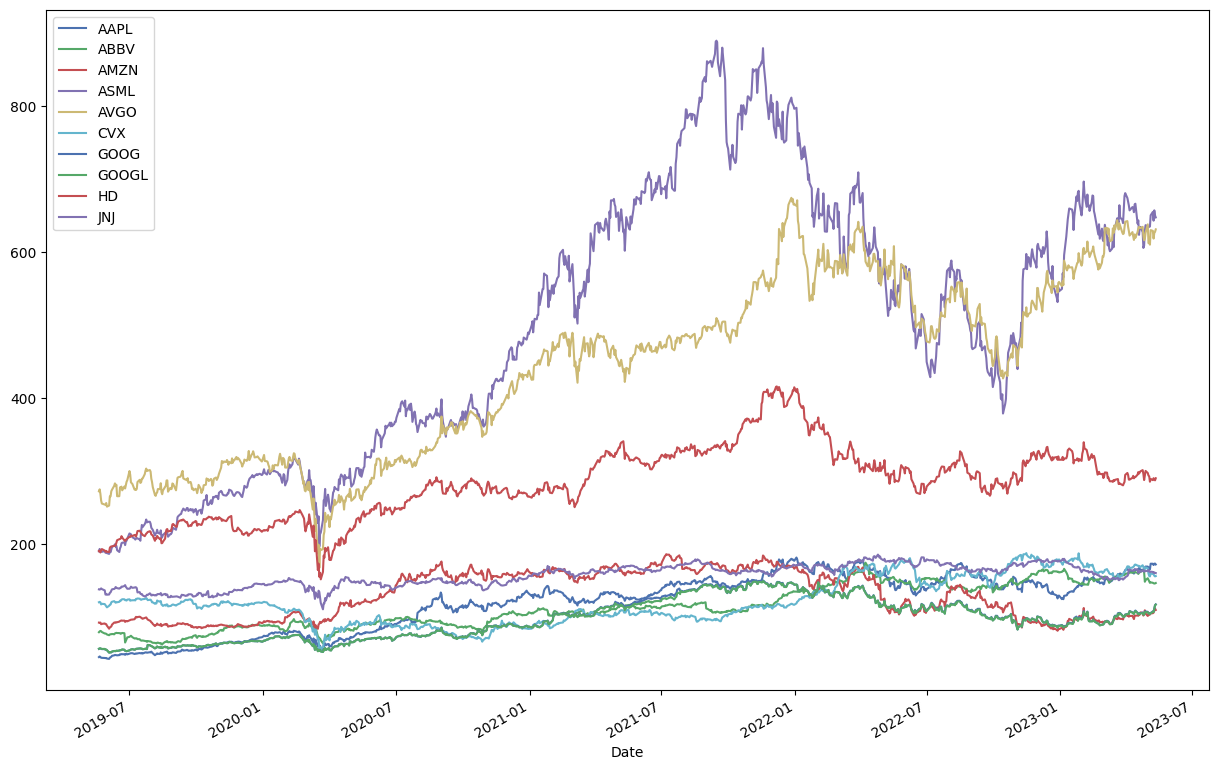

In [97]:
if len(df) >= 10 :
    df.iloc[-1004:, 0:10].plot(figsize=(15,10))
else:
    df.plot(figsize=(15,10))

Теперь сделаем матрицу ковариации наших активов.

<Axes: >

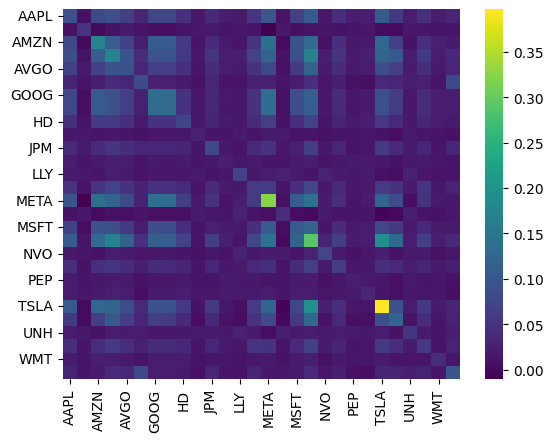

In [104]:
rm = risk_models.risk_matrix(df, method="exp_cov", span=252)
rm = pypfopt.risk_models.fix_nonpositive_semidefinite(rm)

sns.heatmap(rm, cmap='viridis')

Теперь посчитаем оценку для доходностей каждого актива

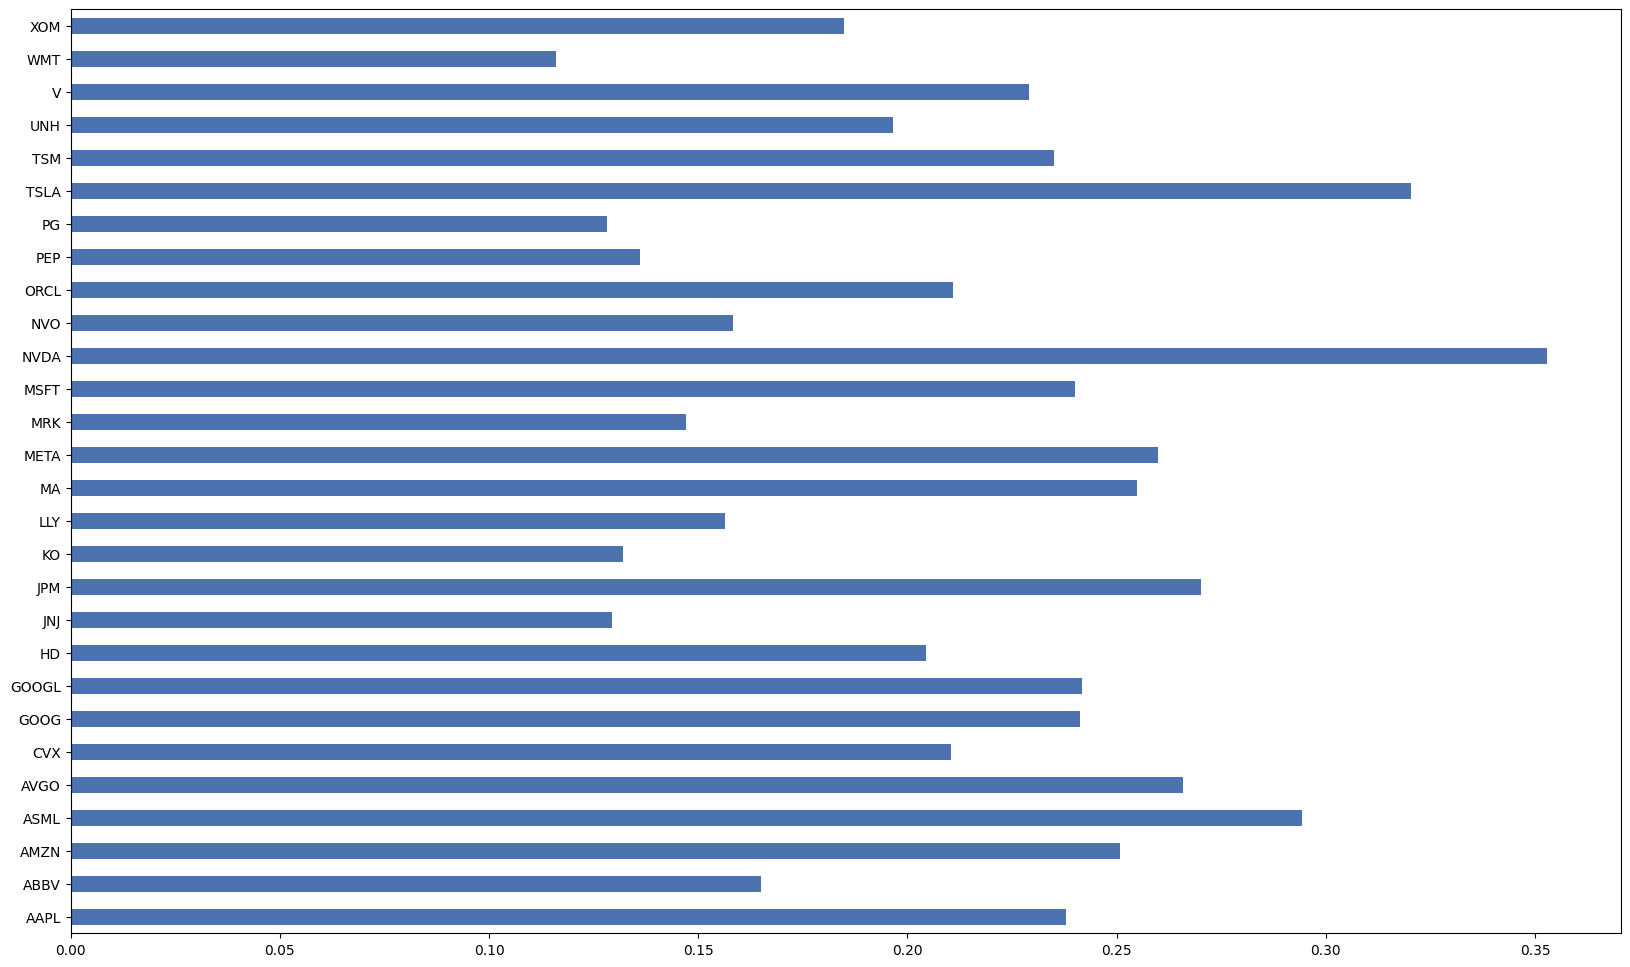

In [99]:
er = expected_returns.return_model(df, method="capm_return")
er.plot.barh(figsize=(20, 12));

Теперь сделаем оптимизацию портфеля

c:\users\mi\appdata\local\programs\python\python39\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Колличество активов в портфеле:  12
Параметры полученого портфеля: 
Expected annual return: 21.1%
Annual volatility: 15.8%
Sharpe Ratio: 1.12
Дискретный портфель с остатком денег: $2.16
{'ABBV': 1, 'JPM': 2, 'MA': 1, 'MRK': 1, 'TSM': 1}


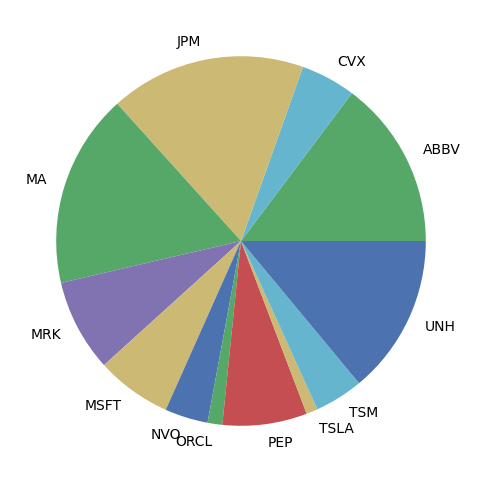

In [122]:
ef = pypfopt.EfficientFrontier(er, rm)
ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=0)  #УВЕЛИЧИТЬ ПАРАМЕТР ГАММА ЕСЛИ ХОЧЕТСЯ БОЛЬШЕ АКЦИЙ В ПОРТФЕЛЕ
ef.max_sharpe(risk_free)

print("Колличество активов в портфеле: ", np.count_nonzero(np.array(list(ef.clean_weights().values()))))
print("Параметры полученого портфеля: ")

ef.portfolio_performance(verbose=True, risk_free_rate=risk_free)

pd.Series(ef.clean_weights(), index = ef.tickers).plot.pie(figsize=(6, 6));

da = pypfopt.DiscreteAllocation(ef.clean_weights(), df.iloc[-1], total_portfolio_value=total_money) #ВЫЧЕСЛИТЬ В ЦЕЛЫХ ЧИСЛАХ
alloc, leftover = da.lp_portfolio()
print(f"Дискретный портфель с остатком денег: ${leftover:.2f}")
print(alloc)

Далее пример кода показывающий как любой случайный портфель ~~отсасывает~~ проигрывает у портфеля найденного методом оптимизации. Создадим случайные 10000 портфелей и сравним с оптимальным

In [107]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(er)), n_samples)
rets = w.dot(er)
stds = np.sqrt((w.T * (rm @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.21692794 0.22649661 0.22760395 ... 0.21567832 0.20696293 0.20701593]
Sample portfolio volatilities: 0       0.196508
1       0.213940
2       0.225938
3       0.194301
4       0.170450
          ...   
9995    0.178703
9996    0.196175
9997    0.210935
9998    0.194105
9999    0.190272
Length: 10000, dtype: float64


c:\users\mi\appdata\local\programs\python\python39\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


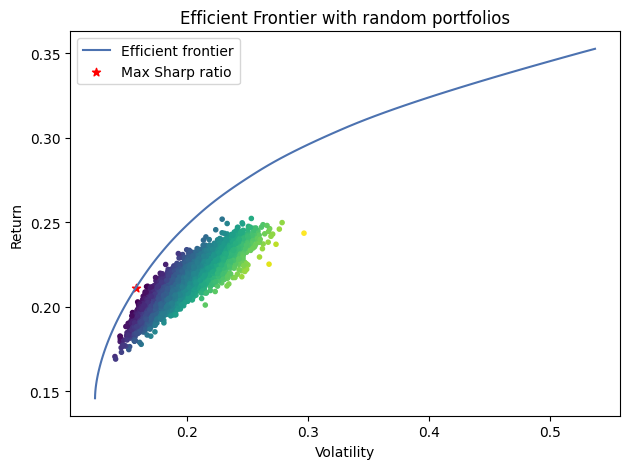

In [108]:
# Plot efficient frontier with Monte Carlo sim
ef = pypfopt.EfficientFrontier(er, rm)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = pypfopt.EfficientFrontier(er, rm)
ef2.max_sharpe(risk_free_rate=0.035)
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

ax.scatter(std_tangent, ret_tangent, marker="*", label="Max Sharp ratio", c="red") 
# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

На данном графике по вертикале доходность, а по горизонтали величина отклонения в год. Грубо говоря наше оптимальное решение в год будет приносить 18% $\pm$ 15%  . Любой портфель не находящийся на фронте эффективности хуже.

In [111]:
df.iloc[-1:]

,AAPL,ABBV,AMZN,ASML,AVGO,CVX,GOOG,GOOGL,HD,JNJ,...,NVO,ORCL,PEP,PG,TSLA,TSM,UNH,V,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-12 00:00:00,172.570007,147.149994,110.260002,647.51001,631.150024,156.619995,117.919998,117.510002,290.470001,160.779999,...,171.270004,97.849998,196.119995,155.960007,167.979996,83.43,491.230011,231.380005,153.070007,105.779999
